<h1><center>Recurrent Neural Network in PyTorch</center></h1>

Table of Contents: <a id=100></a>

1. [Packages](#1)
2. [Data definition](#2)
    - 2.1 [Declaring a tensor `x`](#3)
    - 2.2 [Creating a tensor `y` as a sin function of `x`](#4)
    - 2.3 [Plotting `y`](#5)
3. [Batching the data](#6)
    - 3.1 [Splitting the data in train/test set](#7)
    - 3.2 [Creating the batches of data](#8)
4. [Defining the model](#9)
    - 4.1 [Model class](#10)
    - 4.2 [Model instantiation](#11)
    - 4.3 [Training](#12)
5. [Alcohol Sales dataset](#13)
    - 5.1 [Loading and plotting](#14)
    - 5.2 [Prepare and normalize](#15)
    - 5.3 [Modelling](#16)
    - 5.4 [Predictions](#17)

Recurrent Neural Networks are a type of neural networks that are designed to work on sequence prediction models. RNNs can be used for text data, speech data, classification problems and generative models. Unlike ANNs, RNNs' prediction are based on the past prediction as well as the current input. RNNs are networks with loops in them allowing information to persist.

Each node of an **RNN** consists of 2 inputs:
1. Memory unit
2. Event unit

`M(t-1)` is the memory unit or the output of the previous prediction. `E(t)` is the current event or the information being provided at the present time. `M(t)` is the output of the current node or the output at the present time in the sequence.

### 1. Packages <a id=1></a>
[back to top](#100)

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader

### 2. Data definition <a id=2></a>
[back to top](#100)

In this notebook, I'm going to train a very simple LSTM model, which is a type of RNN architecture to do time series prediction. Given some input data, it should be able to generate a prediction for the next step. I'll be using a **Sin** wave as an example as it's very easy to visualiase the behaviour of a sin wave.


#### 2.1 Declaring a tensor `x` <a id=3></a>

In [24]:
x = torch.linspace(0,799,800)

#### 2.2 Creating a tensor `y` as a sin function of `x` <a id=4></a>

In [25]:
y = torch.sin(x*2*3.1416/40)

#### 2.3 Plotting `y` <a id=5></a>

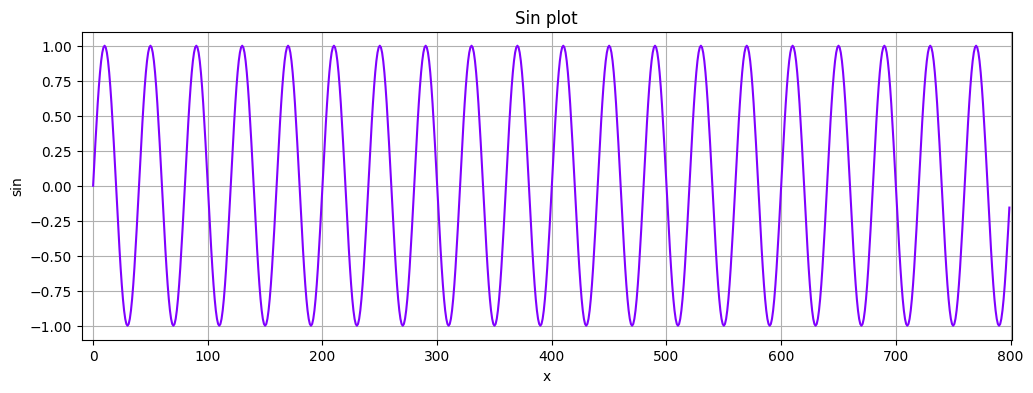

In [26]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(y.numpy(),color='#8000ff')
plt.show()

### 3. Batching the data <a id=6></a>
[back to top](#100)

#### 3.1 Splitting the data in train/test set <a id=7></a>

In [27]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

##### 3.1.1 Plotting the training/testing set

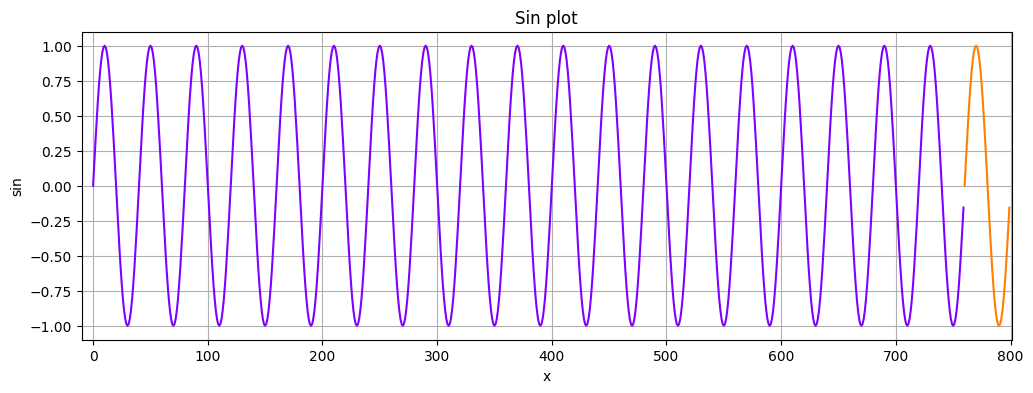

In [28]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000")
plt.show()

#### 3.2 Creating the batches of data <a id=8></a>

While working with LSTM models, we divide the training sequence into series of overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of of 12 records and a window size of 3, we feed [x1, x2, x3] into the model, and compare the prediction to `x4`. Then we backdrop, update parameters, and feed [x2, x3, x4] into the model and compare the prediction to `x5`. To ease this process, I'm defining a function `input_data(seq,ws)` that created a list of (seq,labels) tuples. If `ws` is the window size, then the total number of (seq,labels) tuples will be `len(series)-ws`.

In [29]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

##### 3.2.1 Calling the `input_data` function
The length of `x` = 800

The length of `train_set` = 800 - 40 = 760

The length of `train_data` = 760 - 40 - 720

In [30]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

##### 3.2.2 Checking the 1st value from train_data

In [31]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

### 4. Defining the model <a id=9></a>
[back to top](#100)

#### 4.1 Model Class <a id=10></a>

In [32]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

#### 4.2 Model Instantiation <a id = 11></a>

In [33]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

##### 4.2.1 Printing the model

In [34]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

#### 4.3 Training <a id = 12></a>

During training, I'm visualising the prediction process for the test data on the go. It will give a better understanding of how the training is being carried out in each epoch. The training sequence is represented in <span style="color:#8000ff">purple</span> while the predicted sequence in represented in <span style="color:#ff8000">orange</span>.

Epoch 0 Loss: 0.09212876856327057
Performance on test range: 0.6071590781211853


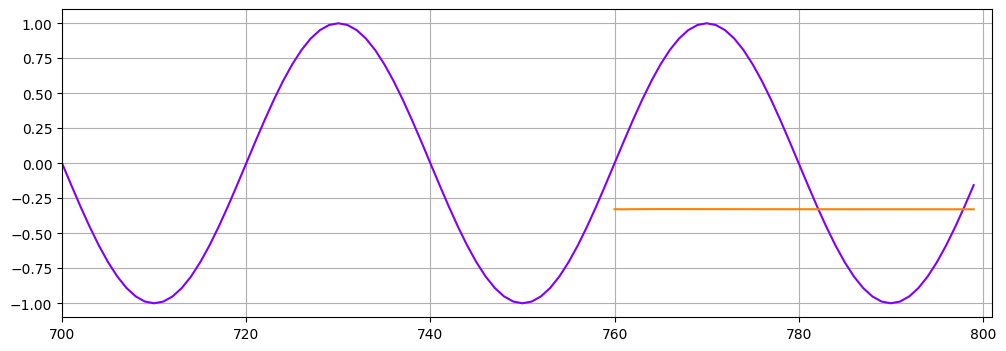

Epoch 1 Loss: 0.06506767123937607
Performance on test range: 0.5650986433029175


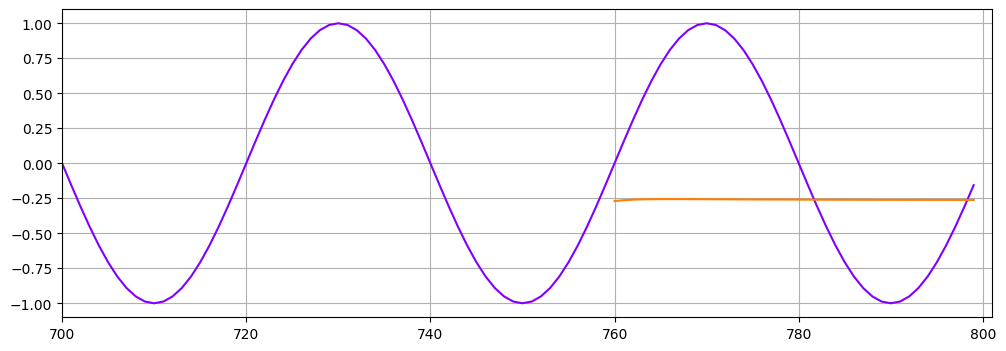

Epoch 2 Loss: 0.041980478912591934
Performance on test range: 0.5199716091156006


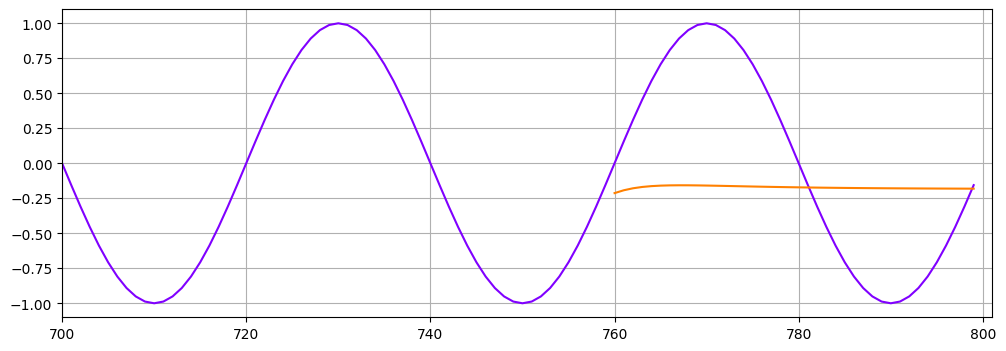

Epoch 3 Loss: 0.017842764034867287
Performance on test range: 0.42209964990615845


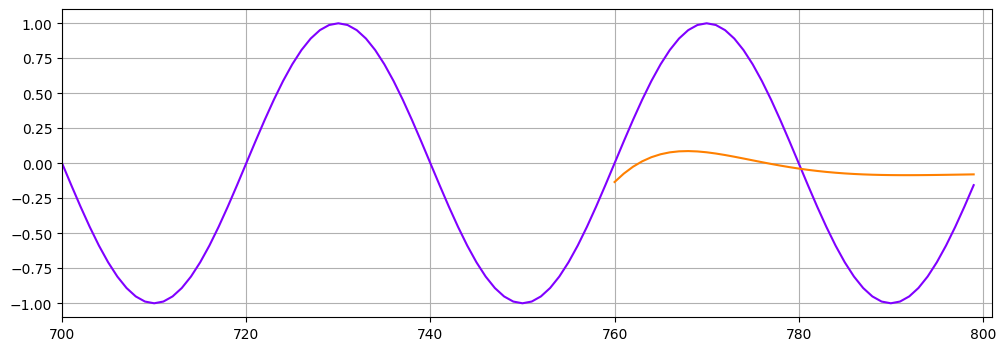

KeyboardInterrupt: 

In [35]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()

### 5. Alcohol Sales dataset <a id=13></a>
[back to top](#100)

#### 5.1 Loading and plotting <a id=14></a>

##### 5.1.1 Importing the data

In [2]:
def open_data(print_head=False, columns=None):
    data = pd.read_csv('Data\LD2011_2014.csv', parse_dates=['LD2011_2014'], index_col='LD2011_2014')
    data.rename(columns={'LD2011_2014': 'Timestamp'}, inplace=True)
    n=0
    for col in data.columns:
        if col != 'timestamp':
            data.rename(columns={col: f"EC_{n}"}, inplace=True)
            n+=1

    def convert_to_float(value):
        try:
            # Replace commas with points and convert to float
            return float(value.replace(',', '.'))
        except:
            # Handle any conversion errors (e.g., non-numeric values)
            return value

    # Apply the custom function to all values in the DataFrame
    data = data.applymap(convert_to_float)

    if columns:
        data = data[columns]

    if print_head:
        print(data.head())

    return data



def plot_data(df, columns=None):
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    elif isinstance(columns, int):
        columns = [df.columns[columns]]
    # Get the list of column names from the DataFrame
    df = df[columns]
    # Determine the number of rows and columns for subplots
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # Adjust this for your layout preference

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(30, num_rows * 4))
    fig.tight_layout(pad=4.0)  # Adjust the padding as needed

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(df.index, df[column])
        ax.set_title(column)
        ax.set_xlabel('Date')  # You can customize the x-axis label
        ax.set_ylabel('Electricity_consumption')  # You can customize the y-axis label

    # Hide any unused subplots (if there are more subplots than columns)
    for j in range(i + 1, num_rows * 2):
        fig.delaxes(axes[j])

    plt.show()


def apply_moving_average(df, columns, k):
    """
    Apply a moving average of order k to specified columns of a Pandas DataFrame.

    Parameters:
    - df: Pandas DataFrame.
    - columns: List of column names to apply the moving average to.
    - k: Order of the moving average.

    Returns:
    - df_ma: A new DataFrame with moving averages applied to specified columns.
    """
    if isinstance(columns, str):
        columns = [columns]
    if isinstance(k, int):
        k = [k] * len(columns)  # Convert k to a list of equal values
    elif isinstance(k, str):
        k = [k] * len(columns)

    df_ma = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data

    for i, col in enumerate(columns):
        df_ma[col] = df[col].rolling(window=k[i]).mean()

    return df_ma

def remove_zeros(df):
    # Find the index of the first non-zero value in the column
    column_name = df.columns[0]
    non_zero_mask = df[column_name] != 0
    first_non_zero_index = df[non_zero_mask].index[0]
    
    # Remove the initial rows with zeros
    df = df.loc[first_non_zero_index:]
    
    return df

C:\Users\jeanb\AppData\Local\Temp\ipykernel_1596\1005590532.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data\LD2011_2014.csv', parse_dates=['LD2011_2014'], index_col='LD2011_

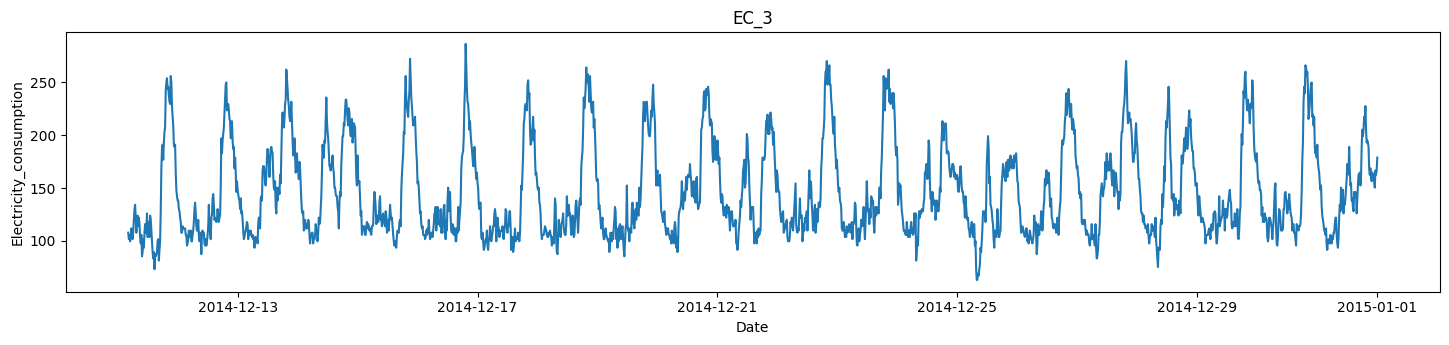

In [45]:
df_ini = open_data(columns=["EC_3"])
#df=apply_moving_average(df_ini, columns=["EC_3"], k=4*24*7*4)
df = df_ini[-2000:]
df.dropna(inplace=True)
df = remove_zeros(df=df)
plot_data(df, "EC_3")

##### 5.1.2 Dropping the empty rows

In [46]:
df.dropna(inplace=True)
len(df)

2000

##### 5.1.3 Plotting the Time Series Data

#### 5.2 Prepare and normalize <a id=15></a>

##### 5.2.1 Preparing the data

In [48]:
#extracting the time series values
y = df['EC_3'].values.astype(float) 

#defining a test size
test_size = 300

#create train and test splits
train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([215.44715447, 199.18699187, 191.05691057, 184.95934959,
       184.95934959, 168.69918699, 168.69918699, 164.63414634,
       152.43902439, 152.43902439, 154.47154472, 142.27642276,
       130.08130081, 123.98373984, 142.27642276, 134.14634146,
       128.04878049, 117.88617886, 117.88617886, 121.95121951,
       119.91869919, 117.88617886, 115.85365854, 111.78861789,
        97.56097561, 103.65853659, 105.69105691, 105.69105691,
       105.69105691, 109.75609756, 111.78861789, 107.72357724,
       101.62601626, 113.82113821, 115.85365854, 109.75609756,
       113.82113821, 126.01626016, 126.01626016, 128.04878049,
       126.01626016, 105.69105691,  97.56097561, 103.65853659,
       115.85365854, 115.85365854, 142.27642276, 113.82113821,
       117.88617886, 119.91869919, 121.95121951, 123.98373984,
       138.21138211, 126.01626016, 130.08130081, 109.75609756,
       130.08130081, 130.08130081, 121.95121951, 123.98373984,
       134.14634146, 138.21138211, 144.30894309, 148.37

##### 5.2.2 Normalize the data

In [49]:
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

##### 5.2.3 Prepare data for LSTM model

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1).to(device)

# define a window size: periode is around two days, we have 24*4 samples per day therefore we need a window size of 24*4*2
window_size = 24*4*2
# define a function to create sequence/label tuples
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# apply input_data to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

1508

##### 5.2.4 Printing the first tuple

In [24]:
train_data[0]

(tensor([-0.9594, -0.9599, -0.9642, -0.9668, -0.9702, -0.9709, -0.9714, -0.9730,
         -0.9769, -0.9802, -0.9828, -0.9838, -0.9876, -0.9912, -0.9933, -0.9948,
         -0.9967, -0.9988, -0.9993, -1.0000, -0.9993, -0.9976, -0.9957, -0.9919,
         -0.9888, -0.9859, -0.9857, -0.9845, -0.9814, -0.9800, -0.9785, -0.9764,
         -0.9716, -0.9652, -0.9621, -0.9575, -0.9547, -0.9521, -0.9478, -0.9449,
         -0.9418, -0.9392, -0.9363, -0.9356, -0.9344, -0.9325, -0.9303, -0.9270,
         -0.9222, -0.9194], device='cuda:0'),
 tensor([-0.9163], device='cuda:0'))

#### 5.3 Modelling <a id=16></a>

##### 5.3.1 Model definition

In [51]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]

##### 5.3.3 Instantiation, loss and optimizer

In [52]:
torch.manual_seed(42)

# instantiate
model = LSTMnetwork().to(device)

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
'''
print(train_data)
train_data = torch.FloatTensor(np.array(train_data)).to(device)'''


model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

##### 5.3.4 Training

Epoch:  1 Loss: 0.00324486
Epoch:  2 Loss: 0.00000280
Epoch:  3 Loss: 0.00108642
Epoch:  4 Loss: 0.00009850
Epoch:  5 Loss: 0.00070254
Epoch:  6 Loss: 0.00377284
Epoch:  7 Loss: 0.00206573
Epoch:  8 Loss: 0.00206145
Epoch:  9 Loss: 0.00093862
Epoch: 10 Loss: 0.00257991
Epoch: 11 Loss: 0.00212898
Epoch: 12 Loss: 0.00197576
Epoch: 13 Loss: 0.00002904
Epoch: 14 Loss: 0.00113381
Epoch: 15 Loss: 0.00219531
Epoch: 16 Loss: 0.00081102
Epoch: 17 Loss: 0.00064221
Epoch: 18 Loss: 0.00172855
Epoch: 19 Loss: 0.00177966
Epoch: 20 Loss: 0.00090711
Epoch: 21 Loss: 0.01431582
Epoch: 22 Loss: 0.00285392
Epoch: 23 Loss: 0.00200472
Epoch: 24 Loss: 0.00911466
Epoch: 25 Loss: 0.00436058
Epoch: 26 Loss: 0.00300263
Epoch: 27 Loss: 0.00303742
Epoch: 28 Loss: 0.00407433
Epoch: 29 Loss: 0.00445629
Epoch: 30 Loss: 0.00551959
Epoch: 31 Loss: 0.00246980
Epoch: 32 Loss: 0.00149349
Epoch: 33 Loss: 0.00112365
Epoch: 34 Loss: 0.00486200
Epoch: 35 Loss: 0.00750108
Epoch: 36 Loss: 0.00428880
Epoch: 37 Loss: 0.00326331
E

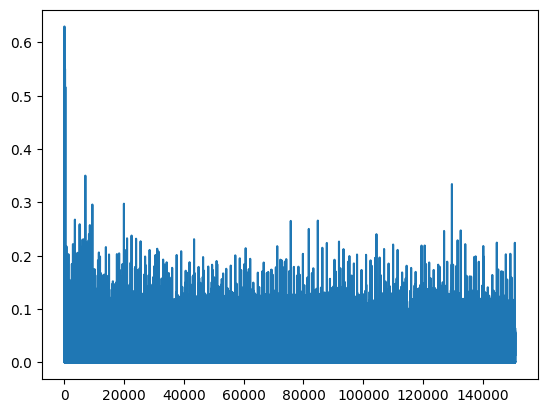

In [53]:
epochs = 100

best_model = model
best_loss = 1000000

import time
start_time = time.time()
losses = []
for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if loss < best_loss:
            best_loss = loss
            best_model = model
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

plt.plot(range(len(losses)), losses)
# put a logscaled y axis
plt.yscale('log')
plt.show()

#### 5.4 Predictions <a id=17></a>

##### 5.4.1 Test set predictions

In [54]:
future = test_size

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(test_size):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
preds[window_size:]

[0.2516258955001831,
 0.1965932995080948,
 0.14488406479358673,
 0.0768730491399765,
 0.003855288028717041,
 -0.07187093794345856,
 -0.14910303056240082,
 -0.22871875762939453,
 -0.3003745675086975,
 -0.36429691314697266,
 -0.42316651344299316,
 -0.47670429944992065,
 -0.5233182907104492,
 -0.5614697337150574,
 -0.5905495285987854,
 -0.611057698726654,
 -0.6242408752441406,
 -0.6315220594406128,
 -0.6341187357902527,
 -0.6328749656677246,
 -0.6281824111938477,
 -0.6201414465904236,
 -0.6087242364883423,
 -0.593959391117096,
 -0.5761089324951172,
 -0.5556853413581848,
 -0.5334818363189697,
 -0.5103253126144409,
 -0.48671430349349976,
 -0.4627467393875122,
 -0.4381011724472046,
 -0.4121816158294678,
 -0.38438183069229126,
 -0.3540942370891571,
 -0.3206767439842224,
 -0.2833815813064575,
 -0.24151448905467987,
 -0.19473831355571747,
 -0.1430552750825882,
 -0.08705377578735352,
 -0.028243303298950195,
 0.03130267560482025,
 0.09000387787818909,
 0.14679960906505585,
 0.20073671638965607,
 

##### 5.4.2 Original test set

In [ ]:
df['S4248SM144NCEN'][-12:]

##### 5.4.3 Inverting the normalised values

In [55]:
true_predictions = scaler.inverse_transform(np.array(preds[:]).reshape(-1, 1))
true_predictions

array([[221.54471418],
       [229.67479772],
       [213.41463396],
       [205.28455375],
       [215.44715568],
       [211.38211225],
       [201.21951198],
       [205.28455375],
       [180.89430896],
       [174.79674797],
       [168.69918698],
       [170.73170745],
       [162.60162599],
       [158.53658588],
       [144.30894218],
       [146.3414639 ],
       [140.24390208],
       [144.30894218],
       [117.88617983],
       [115.85366144],
       [115.85366144],
       [119.91869822],
       [115.85366144],
       [119.91869822],
       [111.78861801],
       [105.69105618],
       [109.75609962],
       [107.72357457],
       [105.69105618],
       [105.69105618],
       [ 97.56097597],
       [ 95.52845759],
       [101.62601941],
       [103.6585378 ],
       [115.85366144],
       [101.62601941],
       [101.62601941],
       [105.69105618],
       [ 99.59349436],
       [ 95.52845759],
       [115.85366144],
       [ 93.49593254],
       [ 83.33333394],
       [ 85

##### 5.4.4 Plotting

In [84]:
df_pred_true = df['EC_3'][-918:-18]
# rename the column "Real_consumption"
df_pred_true = pd.DataFrame(df_pred_true)
df_pred_true.columns = ['Real_consumption']

# Add the predicted consumption to the dataframe
df_pred_true['Predicted_consumption'] = true_predictions
print(len(df_pred_true))
df_pred_true.head()

900


,Real_consumption,Predicted_consumption
LD2011_2014,,
2014-12-22 10:45:00,109.756098,105.691056
2014-12-22 11:00:00,121.951220,115.853661
2014-12-22 11:15:00,117.886179,142.276424
2014-12-22 11:30:00,123.983740,123.983738
2014-12-22 11:45:00,128.048780,123.983738


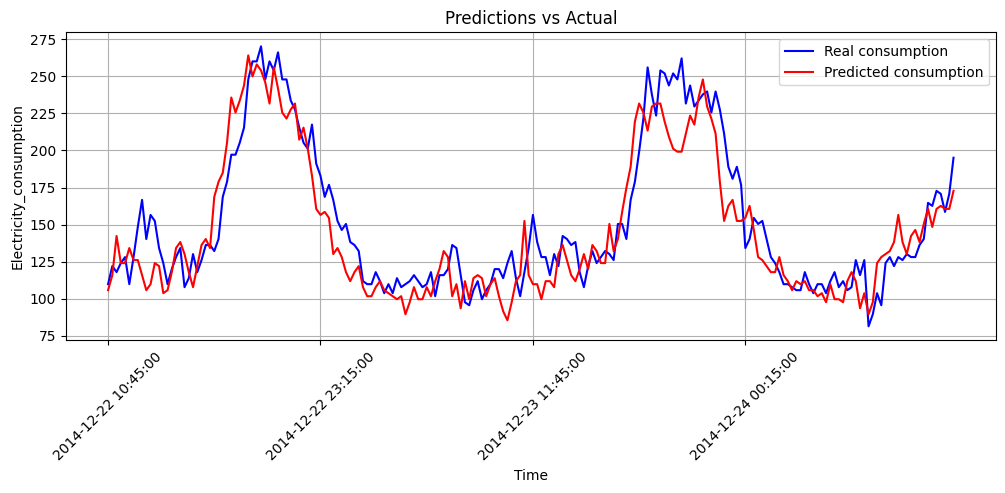

In [92]:
# Plot predictions against known values
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Electricity_consumption")
plt.title("Predictions vs Actual")
plt.plot(df_pred_true["Real_consumption"][:200].values, label = "Real consumption", color='blue')
plt.plot(df_pred_true["Predicted_consumption"][:200].values, label = "Predicted consumption", color='red')

# Plot time from the pd df on the x axis with an angle to make it more readable

plt.xticks(np.arange(0, 200, 50), df_pred_true.index[:200:50], rotation=45)
plt.legend()
plt.show()

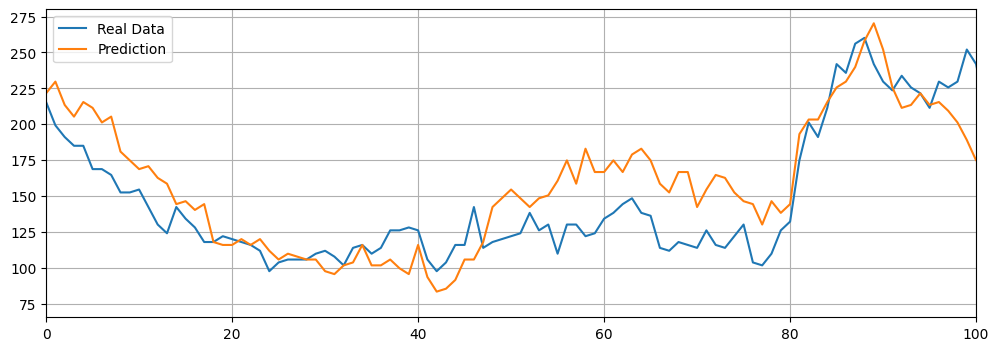

In [56]:
# Plot prediction VS real data in test set
true_values = df['EC_3'][-100:].values
true_values = test_set
plt.figure(figsize=(12,4))
plt.xlim(0,100)
plt.grid(True)
plt.plot(true_values,label='Real Data')
plt.plot(true_predictions.reshape(-1),label='Prediction')
plt.legend()
plt.show()

In [60]:
# Save the whole model 
torch.save(model, 'SVM1.pt')

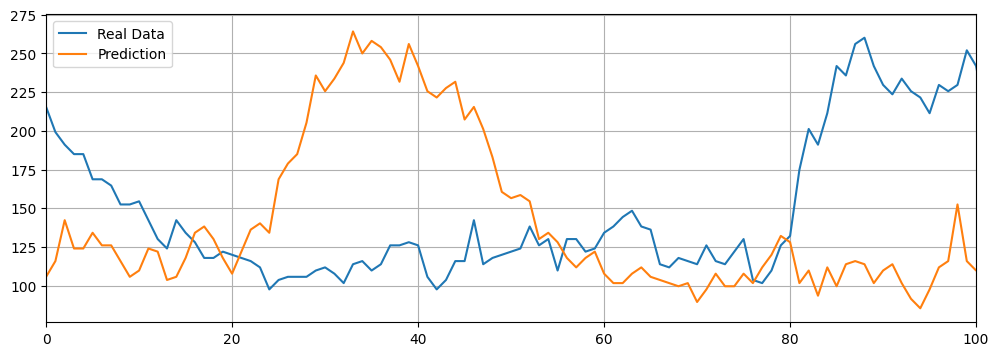

In [59]:
future = test_size

preds = train_norm[-1000:-800].tolist()

best_model.eval()

for i in range(700):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        best_model.hidden = (torch.zeros(1,1,best_model.hidden_size).to(device),
                        torch.zeros(1,1,best_model.hidden_size).to(device))
        preds.append(best_model(seq).item())
true_predictions = scaler.inverse_transform(np.array(preds[:]).reshape(-1, 1))
# Plot prediction VS real data in test set
true_values = df['EC_3'][-800:].values
true_values = test_set
plt.figure(figsize=(12,4))
plt.xlim(0,100)
plt.grid(True)
plt.plot(true_values,label='Real Data')
plt.plot(true_predictions.reshape(-1),label='Prediction')
plt.legend()
plt.show()

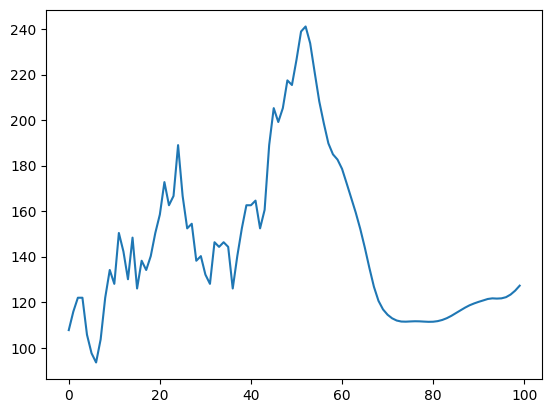

In [15]:
plt.plot(true_predictions)
plt.show()

##### 5.5.5 Zooming the test predictions

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

### If you liked the notebook, consider giving an upvote.
[back to top](#100)